# 2D Seismic Image Vision Searchl

1. [Background](#Background)
2. [Getting Started](#Setup-and-Preprocessing)
  1. [Setup](#Setup)
  2. [Preprocessing](#Preprocessing)
3. [Index Like Images](#Index-Like-Images)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Inference and Evalution](#Inference-And-Evaluation)

## Background

Image Vision Search or Content-based image similarity retrieval is important for upstream oil and gas, as it allows explorers to quickly and automatically find geological analogues in other plays to perform case-based reasoning.

In this demo, Amazon SageMaker along with Keras and Annoy will be used to create 2D seismic image retrival program.
Seismic images will be either Faults or Salts from [Virtual Seismic Atlas](http://www.seismicatlas.org/), with the end goal of search returning relevant images in each category.

## Getting Started

### Setup

To get started, we need to set up the environment with a few prerequisite libarries, configurations, data, and so on.
In this part we will:

* Make sure Keras and Annoy are installed
* Setup Marco-Level variables 
* Download the InceptionResNetV2 pretrained model
* Download images files from S3
* Load images into a numpy array and preprocess 

In [ ]:
!conda install keras=2.2.2 tensorflow=1.8.0 numpy=1.15.0 --yes --quiet
!conda install -c conda-forge python-annoy --yes --quiet 

With prerequisite libraries now installed we can import them into Juypter.

In addition, we will setup macro variables for the number of images to return (*K*), a standard size for all images and the image directory location.

Finally, through one single line we will import a pretrained version of a Convlutional Neural Network CNN, [InceptionResNetV2](https://arxiv.org/abs/1602.07261), with the final layer of the network removed. The CNN will generate features from images by detecting color, texture, object width and relationships. With this defined within a lower dimensional space, it becomes easier to generate image to image comaprisons to find the most like pairs.

In [ ]:
import os
import boto3
from sagemaker import get_execution_role
from glob import glob
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input, decode_predictions
import numpy as np
from annoy import AnnoyIndex
from matplotlib import pyplot as plt

%matplotlib inline

K = 5 # k as top n to return;
IMAGE_SIZE = (224,224,3) #setting image size constraints to 224x224x3
IMAGE_DIR = './data'

# using pre-trained model from image-net and set image size
model = InceptionResNetV2(weights='imagenet', pooling="avg", input_shape=IMAGE_SIZE, include_top=False)

role = get_execution_role()

bucket = 'example-seismic-images' # customize to your bucket

Next, we will obtained the data from S3 and save it to a local directory called 'data'.

In [3]:
!mkdir data
!aws s3 cp s3://"$bucket" ./data/ --recursive --quiet

Sesimic 2D images of Faults and Salts from Virtual Seismic Atlas are now downloaded into the local drive.

Since the names of the directories are labels themselves, all that's left is to make lists of the image file locations and then store the category of each image into a numpy array to later refrence for the image's true category.

In [3]:
# get file paths of all images
salt_images = glob(os.path.join(IMAGE_DIR, "salt/*.jpg"))
fault_images = glob(os.path.join(IMAGE_DIR, "fault/*.jpg"))

# summarise results; combine all paths to single list
all_images = salt_images + fault_images
salt_len, fault_len, comb_len = len(salt_images), len(fault_images), len(all_images)
print("\n There are {0} Salt images and {1} Fault images for a total of {2} images!".format(salt_len, fault_len, comb_len))

# take the folder info from the images to create labels as to which category of seismic they belong to
labels = np.array([all_images[i].split("/")[2] for i in range(comb_len)])


 There are 24 Salt images and 17 Fault images for a total of 41 images!



To look at the first image generated we can now use the **all_images** list of file paths to readin or display the images in our notebook like below.

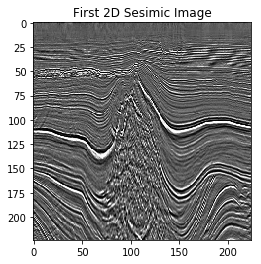

In [4]:
img = image.load_img(all_images[0], grayscale=False, target_size=IMAGE_SIZE)
_ = plt.title("First 2D Sesimic Image")
_ = plt.imshow(img)

## Preprocessing

Now that the environment is setup and we have data - it's time to read the data in to memory!

In the below code we create a helper function **load_image_data** which takes an image provided from a file path and then converts it into a normalized numpy array. Since the majority of the images are in color, we will keep the 3 RGB dimensions and not convert to grayscale.

This function will then be combined with list of file paths we just generated to load all the images into a single preprocessed numpy array.

Lastly, we will run the array through the pretrained InceptionResNetv2 model to generate condensed features from each seismic image.

In [5]:
# create a helper function to load the images in and then convert to normailized numpy array
def load_image_data(file_path):
    """Return images as normalized 3D array"""
    img = image.load_img(file_path, grayscale=False, target_size=IMAGE_SIZE)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return x

In [6]:
%%time

print("Getting Images... \n")
# stacking images into list of numpy arrays
# create a placehodler numpy array and then read in each image, so that all images are stacked into a numpy array
X = np.empty((comb_len, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]))
for i in range(comb_len):
    X[i,:,:,:] = load_image_data(all_images[i])

# use the pretrained model to take the images and then extract features from them
print("Generate Features from pretrained CNN... \n")
image_features = model.predict(X)
n,m = image_features.shape
print("Image features are set as {0} by {1} array \n".format(n,m))

Getting Images... 

Generate Features from pretrained CNN... 

Image features are set as 41 by 1536 array 

CPU times: user 1min 47s, sys: 1.72 s, total: 1min 49s
Wall time: 29.1 s


For a real world production system, thousands of images would be needed for each class.

For this example, we will simply just hold out 2 of the images as 'testing' under the caveat that this is to show how a similarity based system would work and not to prove that it works emperically. 

In [7]:
# split into training and testing sets 
# NOTE: sample is too small for practical purposes but this is just to holdout data as 'untouched' to show results
def training_split_idxs(permutations=comb_len, partition=2):
    """Split into training and testing datasets"""
    np.random.seed(9)
    indices = np.random.permutation(permutations)
    train_idx, test_idx =  indices[partition:],indices[:partition]
    
    return train_idx, test_idx

train_idx, test_idx = training_split_idxs()
print("Splitting into test and train...")
x_train, y_train = image_features[train_idx], labels[train_idx]
x_test, y_test = image_features[test_idx], labels[test_idx]

Splitting into test and train...


Save the training data to the drive for later usage.

In [8]:
!mkdir ./data/training
np.savetxt(IMAGE_DIR + "/training/training_data.csv", x_train, delimiter=",")

## Index Like Images

We now have a vectorized representation of each image work with. Each row of the array is an image and the columns are all features generated by the CNN. 

This means that rather than throwing entirety of an image at the algorithm we will use only relevant textures, colors, etc. to differentiate each image.

However, we have only completed the first step of the process as while data is now in a lower dimensional space, we cannot yet retrieval like images.

The next step will be a mechanism from which that can be done.

Using the popular [Annoy](https://github.com/spotify/annoy) algorithm for approximate nearest neighbors search we take the new feature-space generated from the CNN and map the pairwise distance of each image. 

Having a measure of how far apart or how close each image is via the distance matrix, will allow for an in-memory index to be generated that can quickly call the 'neighbors' of any given image. This will be the mechanism by which an explorer can upload an image and retrieve analogues!

In [9]:
# create annoy based on the vector size then loop through array to index each building an in memory index
annoy_index = AnnoyIndex(x_train.shape[1], metric='angular')

for i in range(len(x_train)):
    annoy_index.add_item(i, x_train[i,:])
    
annoy_index.build(15)

# pull 5 nearest neighbors minus the same image
idxs = np.empty((x_train.shape[0], K))
for i in range(x_train.shape[0]):
     idxs[i,:] = annoy_index.get_nns_by_vector(x_train[i,:].ravel(), K + 1)[1:]
idxs = idxs.astype(np.int32)

print("First test example image neighbors are...")
image_neighbors = [annoy_index.get_nns_by_vector(x_test[i,:].ravel(), K + 1)[1:] for i in range(len(x_test))]
print("Image number {0} is most like images: {1}".format(test_idx[0], image_neighbors[0]))

First test example image neighbors are...
Image number 20 is most like images: [25, 9, 3, 16, 17]


Now an in-memory index is created, which can be queried quickly to provide the most similar sesimic images that it was built over.

Likewise, this can be further productionalized by containerizing to SageMaker and pushing out as an API endpoint.

## Setup Hosting Model

This involves creating a SageMaker model from the model file previously uploaded to S3.

### Import model into hosting

In [11]:
%%capture
%%sh 

# The name of our algorithm
algorithm_name=annoy

cd container

chmod +x annoy/train
chmod +x annoy/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

In [12]:
prefix = 'annoy'

# Define IAM role
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
import sagemaker as sage

role = get_execution_role()

sess = sage.Session()

In [13]:
# need to write as csv then upload to S3
data_location = sess.upload_data(IMAGE_DIR + "/training/training_data.csv", bucket=bucket, key_prefix=prefix)

In [14]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/annoy:latest'.format(account, region)

In [15]:
clf = sage.estimator.Estimator(image,
                       role, 1, 'ml.c4.2xlarge',
                       output_path = "s3://{}/{}".format(bucket, prefix),
                       sagemaker_session=sess)

clf.fit(data_location)

INFO:sagemaker:Creating training-job with name: annoy-2018-08-14-12-28-46-035


.............
/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, m

### Create endpoint

SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, you can create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

In [16]:
from sagemaker.predictor import csv_serializer
predictor = clf.deploy(1, 'ml.m4.xlarge', serializer=csv_serializer)

INFO:sagemaker:Creating model with name: annoy-2018-08-14-12-31-27-909
INFO:sagemaker:Creating endpoint with name annoy-2018-08-14-12-28-46-035


--------------------------------------------------------------!

In [17]:
predictions = predictor.predict(x_test).decode('utf-8').split("\n")[:-1]
print(predictions)

[u'"[18, 25, 9, 3, 16]"', u'"[15, 3, 22, 23, 19]"']


## Inference and Evaluation

First, let's check the overall revelance at each K and then the overall average precision as it relates to relevance.

In practice, relevance for image retrival can go much deeper but for simplicity's sake, we will define relevance here as a returned result matching the category of the image it is paired to. That means that if the index matches a fault image to a fault we will score it as a '1' meaning it was relevant, with a score '0' meaning the returned image was actually a salt. The same will be done for salt images.

In [18]:
# flag relevant features based on if class matches the neighbor 1 or does not 0
relevance = np.empty(idxs.shape)

for i in range(len(idxs)):
    relevance[i,:] = np.where(y_train[i] == y_train[idxs[i,:]], 1,0)

def precision_at_k(relevance):
    """Returns the precision at chosen K"""
    denominator = [len(relevance)*(i+1) for i in range(relevance.shape[1])]
    numerator = np.cumsum(np.sum(relevance, axis=0))
    return numerator / denominator

relevance_at_k = precision_at_k(relevance)

print("\n Relevance at each k : {0}".format(np.round(relevance_at_k,4)))
print("\n Average precision : {0}".format(np.round(np.mean(relevance_at_k),4)))


 Relevance at each k : [0.9231 0.859  0.8376 0.7949 0.7641]

 Average precision : 0.8357


In the case of the training examples, our model is most accurate at K=1, with degredation after each level of K.

This evens out to an overall Average Precision of 0.778 which means that almost 8 out of 10 results are relevant based on our criteria.

Given that current feature extraction uses an untuned model, trained on images of cats,dogs and such (not seisimic images) results are not too shabby!


As an additional step, we can take a look at the results we heldout and see if model's results pass the qualitative check.

./data/fault/fault14.jpg


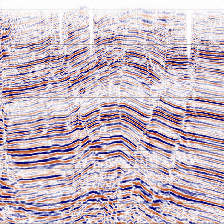

In [19]:
from keras.preprocessing import image

print(all_images[test_idx[1]])
image.load_img(all_images[test_idx[1]], target_size=IMAGE_SIZE)

./data/salt/salt17.jpg
./data/salt/salt22.jpg
./data/salt/salt6.jpg
./data/salt/salt2.jpg
./data/fault/fault16.jpg


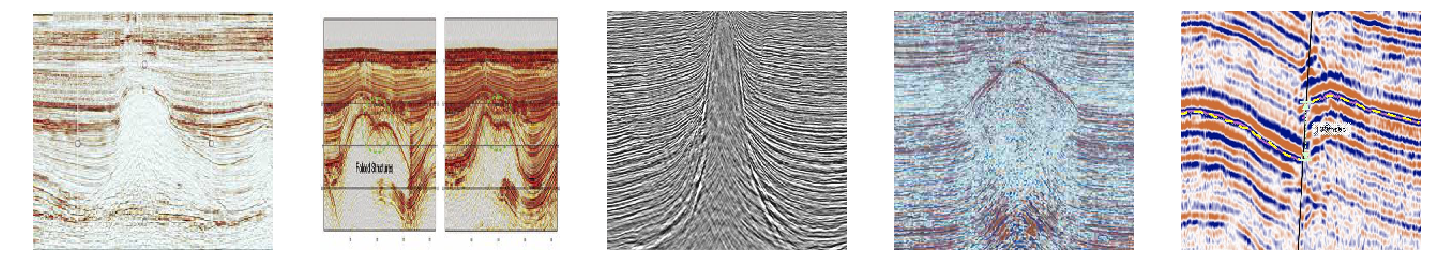

In [21]:
for i in range(K):
    img_idx = image_neighbors[1][i]
    image_to_load = all_images[img_idx]
    print(image_to_load)
    img = image.load_img(image_to_load, target_size=IMAGE_SIZE)
    fig = plt.gcf()
    plt.subplot(3,6,i+1)
    plt.axis('off')
    fig.set_size_inches(30, 30, forward=True)
    plt.imshow(img)